### import

In [80]:
import os
import json
import logging
from pathlib import Path
from typing import List, Dict, Optional, Tuple
import pandas as pd
import numpy as np

# Display and Image handling
from IPython.display import display
from PIL import Image as PILImage  # 使用 PILImage 作为 PIL.Image 的别名
from IPython.display import Image as IPyImage  # 使用 IPyImage 作为 IPython 的 Image

# Vector DB
import chromadb
from chromadb.utils import embedding_functions

# Embedding Models
from sentence_transformers import SentenceTransformer
from transformers import CLIPProcessor, CLIPModel
import torch

# LLM
import ollama

# PDF处理
import PyPDF2

# 设置日志
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# 检查并创建必要的目录
Path('chroma_db').mkdir(exist_ok=True)
Path('image').mkdir(exist_ok=True)

In [81]:
import sys
import torch
import transformers
import accelerate
print(f"Python version: {sys.version}")
print(f"PyTorch version: {torch.__version__}")
print(f"Transformers version: {transformers.__version__}")
print(f"Accelerate version: {accelerate.__version__}")

Python version: 3.9.19 | packaged by conda-forge | (main, Mar 20 2024, 12:55:20) 
[Clang 16.0.6 ]
PyTorch version: 2.5.1
Transformers version: 4.47.0
Accelerate version: 0.26.0


### voice to text


In [82]:
# whisper /Users/zirong/Desktop/test.mp4 --language Chinese --model tiny
import whisper
def transcribe_file(file_path, model_size="base"):
    model = whisper.load_model(model_size)
    result = model.transcribe(file_path)
    return result["text"]

# def main():
#     audio_file = "no_upload/test_mp3/01.mp3"  # 修改為你的音檔路徑
#     transcription = transcribe_file(audio_file)
#     print("Transcription:", transcription)

# if __name__ == "__main__":
#     main()

### 圖片處理

In [83]:
from typing import Union  # 添加 Union 导入

class ImageProcessor:
    def __init__(self, image_dir: str = "image"):
        self.image_dir = Path(image_dir)
        self.image_dir.mkdir(exist_ok=True)
        
    def process_and_save(
        self,
        image_path: Union[str, Path],  # 使用 Union 替代 |
        target_size: Tuple[int, int],
        prefix: str = "resized_",
        quality: int = 95
    ) -> Optional[Path]:
        """统一的图片处理方法，处理并保存图片"""
        try:
            # 确保 image_path 是 Path 对象
            image_path = Path(image_path)
            if not str(image_path).startswith(str(self.image_dir)):
                image_path = self.image_dir / image_path
                
            # 检查图片是否存在
            if not image_path.exists():
                logger.error(f"Image not found: {image_path}")
                return None
                
            # 读取并处理图片
            image = PILImage.open(image_path)
            
            # 转换为 RGB 模式
            if image.mode != 'RGB':
                image = image.convert('RGB')
                
            # 计算等比例缩放的大小
            width, height = image.size
            ratio = min(target_size[0]/width, target_size[1]/height)
            new_size = (int(width * ratio), int(height * ratio))
            
            # 缩放图片
            image = image.resize(new_size, PILImage.Resampling.LANCZOS)
            
            # 创建新的白色背景图片
            new_image = PILImage.new('RGB', target_size, (255, 255, 255))
            
            # 计算居中位置
            x = (target_size[0] - new_size[0]) // 2
            y = (target_size[1] - new_size[1]) // 2
            
            # 贴上缩放后的图片
            new_image.paste(image, (x, y))
            
            # 生成输出路径
            output_path = self.image_dir / f"{image_path.name}" #output_path = self.image_dir / f"{prefix}{image_path.name}"
            # 保存处理后的图片
            new_image.save(output_path, quality=quality)
            logger.info(f"Saved processed image to: {output_path}")
            
            return output_path
            
        except Exception as e:
            logger.error(f"Error processing image {image_path}: {str(e)}")
            return None
            
    def load_for_display(self, 
                        image_path: Union[str, Path],  # 使用 Union 替代 |
                        display_size: Tuple[int, int]) -> Optional[PILImage.Image]:
        """载入图片用于显示"""
        try:
            processed_path = self.process_and_save(image_path, display_size, prefix="display_")
            if processed_path:
                return PILImage.open(processed_path)
            return None
        except Exception as e:
            logger.error(f"Error loading image for display {image_path}: {str(e)}")
            return None

### Embedding 處理模組

In [84]:
%matplotlib inline
# from IPython.display import display, Image
class HybridEmbeddingProcessor:
    # 初始化 embedding processor
    def __init__(self, 
                persist_directory: str = "chroma_db",
                image_dir: str = "image",
                image_size: tuple = (224, 224)):
        self.image_dir = Path(image_dir)
        self.image_size = image_size
        self.image_processor = ImageProcessor(image_dir)
        
        # 初始化模型
        self.text_model = SentenceTransformer('all-mpnet-base-v2')
        self.clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
        self.clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
        
        # 設置 Chroma，使用已下載的 SentenceTransformer
        logger.info(f"Initializing Chroma with directory: {persist_directory}")
        self.chroma_client = chromadb.PersistentClient(path=persist_directory)
        
        # 創建或獲取集合，使用 SentenceTransformer embedding function
        sentence_transformer_ef = embedding_functions.SentenceTransformerEmbeddingFunction(
            model_name='all-mpnet-base-v2',
            device="cpu"  # 明確指定設備
        )
        
        try:
            # 先嘗試刪除現有的集合（如果存在）
            try:
                self.chroma_client.delete_collection("text_documents")
                self.chroma_client.delete_collection("image_documents")
                logger.info("Deleted existing collections")
            except:
                logger.info("No existing collections to delete")
            
            # 創建新的集合
            self.text_collection = self.chroma_client.create_collection(
                name="text_documents",
                embedding_function=sentence_transformer_ef
            )
            
            self.image_collection = self.chroma_client.create_collection(
                name="image_documents"
            )
            logger.info("Created new collections")
            
        except Exception as e:
            logger.error(f"Error initializing collections: {str(e)}")
            raise
        
        logger.info("Initialized hybrid embedding system")

    def process_image(self, image_path: str) -> Optional[np.ndarray]:
            """處理圖片並生成 embedding"""
            try:
                logger.info(f"Processing image: {image_path}")
                processed_path = self.image_processor.process_and_save(
                    image_path=image_path,
                    target_size=self.image_size
                )
                
                if processed_path is None:
                    logger.error(f"Failed to process image: {image_path}")
                    return None
                    
                image = PILImage.open(processed_path)
                inputs = self.clip_processor(images=image, return_tensors="pt")
                image_features = self.clip_model.get_image_features(**inputs)
                
                logger.info(f"Successfully generated embedding for image: {image_path}")
                return image_features.detach().numpy()[0]
                
            except Exception as e:
                logger.error(f"Error processing image {image_path}: {str(e)}")
                return None

    def add_documents(self, 
                     texts: List[str], 
                     metadatas: List[Dict],
                     images: Optional[List[str]] = None):
        """添加文件到不同的集合"""
        try:
            # 添加文本文件
            if texts and metadatas:
                logger.info(f"Adding {len(texts)} text documents")
                self.text_collection.add(
                    documents=texts,
                    metadatas=metadatas,
                    ids=[f"text_{i}" for i in range(len(texts))]
                )
                logger.info("Successfully added text documents")
            
            # 處理並添加圖片
            if images:
                logger.info(f"Processing {len(images)} images")
                image_embeddings = []
                valid_images = []
                valid_metadatas = []
                
                for i, img_path in enumerate(images):
                    logger.info(f"Processing image {i+1}/{len(images)}: {img_path}")
                    embedding = self.process_image(str(self.image_dir / img_path))
                    if embedding is not None:
                        image_embeddings.append(embedding.tolist())
                        valid_images.append(img_path)
                        valid_metadatas.append({
                            "type": "image", 
                            "path": img_path,
                            "associated_text": texts[i] if i < len(texts) else ""
                        })
                
                if valid_images:
                    logger.info(f"Adding {len(valid_images)} valid images to collection")
                    self.image_collection.add(
                        embeddings=image_embeddings,
                        metadatas=valid_metadatas,
                        ids=[f"img_{i}" for i in range(len(valid_images))]
                    )
                    logger.info("Successfully added images to collection")
                else:
                    logger.warning("No valid images to add to collection")
        
        except Exception as e:
            logger.error(f"Error adding documents: {str(e)}", exc_info=True)
            raise
    
    def process_text(self, text: str) -> np.ndarray:
        """使用 SentenceTransformer 處理文本"""
        try:
            embedding = self.text_model.encode(text)
            return embedding
        except Exception as e:
            logger.error(f"Error processing text: {str(e)}")
            return None
        
    def search(self, query: str, k: int = 3) -> Dict:
        """改進的搜索方法"""
        try:
            logger.info("Starting search operation...")
            
            # 檢查集合是否存在
            if not self.text_collection or not self.image_collection:
                logger.error("Collections not initialized properly")
                return {
                    "texts": {"documents": [[]], "metadatas": [[]], "distances": []},
                    "images": {"metadatas": [[]], "documents": [], "distances": []}
                }

            # 文本搜索
            text_results = self.text_collection.query(
                query_texts=[query],
                n_results=k
            )
            
            # 圖片搜索
            try:
                inputs = self.clip_processor(
                    text=[query], 
                    return_tensors="pt", 
                    padding=True,
                    truncation=True,
                    max_length=77
                )
                text_features = self.clip_model.get_text_features(**inputs)
                query_embedding = text_features.detach().numpy()[0]
                query_embedding = query_embedding / np.linalg.norm(query_embedding)
                
                image_results = self.image_collection.query(
                    query_embeddings=[query_embedding.tolist()],
                    n_results=k
                )
                logger.info(f"Found {len(image_results['metadatas'][0]) if image_results['metadatas'] else 0} images")
                
            except Exception as e:
                logger.error(f"Error in image search: {str(e)}")
                image_results = {
                    "ids": [], 
                    "documents": [], 
                    "metadatas": [[]], 
                    "distances": []
                }
            
            return {
                "texts": text_results,
                "images": image_results
            }
            
        except Exception as e:
            logger.error(f"Search error: {str(e)}")
            return {
                "texts": {"documents": [[]], "metadatas": [[]], "distances": []},
                "images": {"metadatas": [[]], "documents": [], "distances": []}
            }

    def display_search_results(self, query: str, k: int = 3, display_size: tuple = (400, 400)):
        """顯示搜索結果"""
        results = self.search(query, k)
        
        print(f"Query: {query}\n")
        
        # 顯示圖片結果
        if results["image_relevance"] >= 0.3 and results["images"]["metadatas"]:
            print("Related Images:")
            try:
                for i, meta in enumerate(results["images"]["metadatas"][0], 1):
                    print(f"\nImage {i}:")
                    
                    # 使用統一的圖片處理方法載入圖片
                    img = self.image_processor.load_for_display(
                        image_path=meta['path'],
                        display_size=display_size
                    )
                    
                    if img is not None:
                        # 顯示圖片
                        display.display(display.Image(data=img.tobytes()))
                        
                        if 'associated_text' in meta:
                            print(f"Context: {meta['associated_text'][:200]}...")
                            
            except Exception as e:
                logger.error(f"Error displaying images: {str(e)}")
                print("Error displaying images")
        else:
            if results["image_relevance"] < 0.3:
                print("No images needed for this query")
            else:
                print("No relevant images found")

### 資料處理模組

In [85]:
class DataProcessor:
    def __init__(self, embedding_processor: HybridEmbeddingProcessor):
        self.embedding_processor = embedding_processor
        
    def process_csv_with_images(self, csv_path: str) -> Tuple[List[str], List[Dict], List[str]]:
        """處理 CSV 並提取圖片，確保 metadata 值都是基本類型"""
        logger.info(f"Processing CSV: {csv_path}")
        texts = []
        metadatas = []
        images = []
        
        df = pd.read_csv(csv_path)
        current_post = None
        current_responses = []
        current_images = []
        current_metadata = None
        
        for _, row in df.iterrows():
            # 開始新的貼文
            if pd.notna(row['post']):
                if current_post is not None:
                    # 保存前一個貼文
                    text = f"{current_post} {' '.join(current_responses)}"
                    texts.append(text)
                    if current_images:
                        current_metadata["images"] = ",".join(current_images)
                        images.extend(current_images)
                    # 將回應列表轉換為字符串，使用 | 作為分隔符
                    current_metadata["responses"] = "|".join(current_responses)
                    metadatas.append(current_metadata)
                
                # 初始化新貼文
                current_post = row['post']
                current_responses = []
                current_images = []
                current_metadata = {
                    "type": "social_post",
                    "source": "facebook",
                    "is_post": True,
                    "original_post": current_post
                }
                
                # 添加連結（如果有）
                if pd.notna(row['link']):
                    current_metadata["link"] = row['link']
            
            # 添加回覆
            if pd.notna(row['responses']):
                current_responses.append(row['responses'])
                
            # 處理圖片
            if pd.notna(row.get('images')):
                img_path = row['images']
                current_images.append(img_path)
                logger.info(f"Found image: {img_path} for current post")
        
        # 保存最後一個貼文
        if current_post is not None:
            text = f"{current_post} {' '.join(current_responses)}"
            texts.append(text)
            if current_images:
                current_metadata["images"] = ",".join(current_images)
                images.extend(current_images)
            # 將回應列表轉換為字符串
            current_metadata["responses"] = "|".join(current_responses)
            metadatas.append(current_metadata)
        
        # 顯示處理結果的詳細資訊
        for i, (text, meta) in enumerate(zip(texts, metadatas)):
            logger.info(f"\nPost {i+1}:")
            logger.info(f"Content: {text[:100]}...")
            logger.info(f"Images: {meta.get('images', 'No images')}")
            # 使用 split('|') 代替 split('\n')
            logger.info(f"Responses: {len(meta.get('responses', '').split('|'))} replies")
            logger.info(f"Link: {meta.get('link', 'No link')}")
        
        return texts, metadatas, images

    def process_pdf(self, pdf_path: str) -> List[Dict]:
        """處理 PDF 文件，確保 metadata 值都是基本類型"""
        logger.info(f"Processing PDF: {pdf_path}")
        documents = []
        
        try:
            with open(pdf_path, 'rb') as file:
                pdf_reader = PyPDF2.PdfReader(file)
                for page_num, page in enumerate(pdf_reader.pages):
                    text = page.extract_text()
                    paragraphs = [p.strip() for p in text.split('\n\n') if p.strip()]
                    
                    for para in paragraphs:
                        documents.append({
                            'content': para,
                            'metadata': {
                                'source': pdf_path,
                                'page': str(page_num + 1),  # 轉換為字符串
                                'type': 'pdf',
                                'content_length': str(len(para))  # 添加額外信息，也確保是字符串
                            }
                        })
            
            logger.info(f"Extracted {len(documents)} paragraphs from PDF")
            return documents
        except Exception as e:
            logger.error(f"Error processing PDF {pdf_path}: {str(e)}")
            return []

    def process_all(self, csv_path: str, pdf_path: str):
        """處理所有資料，確保所有 metadata 正確"""
        logger.info("Starting to process all documents...")
        
        try:
            # 處理 CSV 和圖片
            texts, metadatas, images = self.process_csv_with_images(csv_path)
            logger.info(f"\nFound {len(images)} images:")
            for img in images:
                logger.info(f"- {img}")
            
            # 檢查圖片文件是否存在
            image_dir = Path("image")
            valid_images = []
            for img in images:
                img_path = image_dir / img
                if img_path.exists():
                    logger.info(f"Image file exists: {img_path}")
                    valid_images.append(img)
                else:
                    logger.error(f"Image file not found: {img_path}")
            
            # 處理 PDF
            pdf_docs = self.process_pdf(pdf_path)
            texts.extend([doc['content'] for doc in pdf_docs])
            metadatas.extend([doc['metadata'] for doc in pdf_docs])
            
            logger.info(f"\nProcessing summary:")
            logger.info(f"- Total texts: {len(texts)}")
            logger.info(f"- Total valid images: {len(valid_images)}")
            
            # 最終檢查確保所有 metadata 值都是基本類型
            for meta in metadatas:
                for key, value in list(meta.items()):
                    if isinstance(value, (list, dict)):
                        meta[key] = str(value)
            
            # 添加到 Chroma
            self.embedding_processor.add_documents(
                texts=texts,
                metadatas=metadatas,
                images=valid_images
            )
            
            logger.info(f"Successfully processed all documents")
            return len(texts), len(valid_images)
            
        except Exception as e:
            logger.error(f"Error processing documents: {str(e)}")
            raise

### QA系統模組

In [86]:
role = """
You are a professional veterinarian specializing in:

Diagnosis and care of Canine Cognitive Dysfunction Syndrome (CCD)
Pet behavior problem diagnosis and improvement suggestions
"""

In [87]:
task = """
Please handle user questions according to the following steps:
Please refer to the references provided below to answer
Step 1: Determine if images are needed in the system response
Based on the question content:

Environment-related: Space planning, facility placement, equipment usage, etc.
Behavior-related: Posture, movement, physical appearance, etc.
Care-related: Wheelchairs, activity areas, equipment usage, etc.
Product recommendations: Medications, assistive devices

Step 2: Provide recommendations
Text response:

Provide professional advice based on textual information
Explain relevant symptoms and precautions
If there are relevant images, naturally incorporate image descriptions into the content
For example:
"Consider using MCT oil (as shown in Figure 1) for nutritional supplementation"
"Veterinarians may prescribe cognitive support medications (such as CogniCaps shown in Figure 2)"

If images are needed:

Find appropriate photos from reference materials
Naturally embed image descriptions within relevant recommendations rather than placing them all at the end
Explain how the images relate to the recommendations (e.g., this is the recommended nutritional supplement, this is a commonly prescribed medication, etc.)
If images are needed but not available in reference materials, proceed without images

Step 3: Response format

Symptom/problem analysis
Professional advice explanation
Recommendations based on community-collected data
Necessary medical reminders
If reference materials are used, mark the source at the end of the response, e.g., [xxx.pdf] or [Link] for community post references

Please respond with empathy and a professional tone.
"""

In [88]:
class QASystem:
    def __init__(self, embedding_processor: 'HybridEmbeddingProcessor',
                 model_name: str = 'llama3.2-vision'):
        self.embedding_processor = embedding_processor
        self.model_name = model_name
        logger.info(f"Initialized QA System with Ollama model: {model_name}")

    def generate_response(self, query: str) -> Tuple[str, List[str]]:
        """Generate response using Ollama"""
        try:
            # Search for relevant content
            search_results = self.embedding_processor.search(query)
            
            # Get context and format prompt
            context = self.format_context(search_results)
            
            # Prepare the base message
            message = {
                'role': 'user',
                'content': f"""{role}

{task}

User Question: {query}

Reference Materials:
{context}
"""
            }

            # Handle single most relevant image
            image_paths = []
            logger.info("Search results for images: %s", search_results["images"])
            if (search_results["images"]["metadatas"] and 
                search_results["images"]["metadatas"][0]):
                # Just take the first (most relevant) image
                metadata = search_results["images"]["metadatas"][0][0]
                logger.info("Selected metadata: %s", metadata)
                img_path = self.embedding_processor.image_dir / metadata["path"]
                logger.info("Checking image path: %s", img_path)
                logger.info("Image exists: %s", img_path.exists())
                if img_path.exists():
                    abs_path = str(img_path.resolve())
                    logger.info("Using absolute image path: %s", abs_path)
                    image_paths.append(abs_path)
                    message['images'] = [abs_path]
                    try:
                        # Verify image can be opened
                        with PILImage.open(abs_path) as img:
                            logger.info("Successfully verified image: %s, size: %s", abs_path, img.size)
                    except Exception as e:
                        logger.error("Error verifying image %s: %s", abs_path, str(e))

            # Generate response using Ollama
            response = ollama.chat(
                model=self.model_name,
                messages=[message]
            )

            return response['message']['content'], image_paths

        except Exception as e:
            logger.error(f"Error generating response: {str(e)}")
            error_msg = "Sorry, an error occurred while processing your question. "
            if "vision model only supports a single image" in str(e):
                error_msg += "There was an issue processing the images."
            return error_msg, []

    def format_context(self, search_results: Dict) -> str:
        """Format context from search results"""
        try:
            context = ""
            
            # Add text results
            if (search_results["texts"]["documents"] and 
                search_results["texts"]["documents"][0] and 
                search_results["texts"]["metadatas"] and 
                search_results["texts"]["metadatas"][0]):
                
                for doc, meta in zip(
                    search_results["texts"]["documents"][0],
                    search_results["texts"]["metadatas"][0]
                ):
                    if meta["type"] == "pdf":
                        context += f"[Medical Literature]\n{doc}\n\n"
                    else:
                        context += f"[Community Discussion]\n{doc}\n"
                        if meta.get("link"):
                            context += f"Source: {meta['link']}\n\n"
            
            # Add information about the most relevant image if available
            if (search_results.get("image_relevance", 0) >= 0.3 and 
                search_results["images"].get("metadatas") and 
                search_results["images"]["metadatas"][0]):
                
                context += "\n[Most Relevant Image]\n"
                meta = search_results["images"]["metadatas"][0][0]
                context += f"- {meta['path']}\n"
            
            return context
            
        except Exception as e:
            logger.error(f"Error formatting context: {str(e)}")
            return "Unable to retrieve reference materials"

    def display_response(self, query: str):
        """Display response with text and images"""
        try:
            logger.info("Starting to generate response...")
            response_text, image_paths = self.generate_response(query)
            
            print("Question:", query)
            print("\nSystem Response:")
            print(response_text)
            print("\n" + "-"*50 + "\n")

            if image_paths:
                print("\nRelated Image:")
                img_path = image_paths[0]  # We now only have one image
                try:
                    img = PILImage.open(img_path)
                    display(IPyImage(filename=img_path))
                except Exception as e:
                    logger.error(f"Error displaying image {img_path}: {str(e)}")
            else:
                logger.info("No images to display")
                
        except Exception as e:
            logger.error(f"Error in display_response: {str(e)}", exc_info=True)

### 系統初始化和資料處理

In [89]:
# 初始化 embedding processor
embedding_processor = HybridEmbeddingProcessor(
    image_size=(224, 224)  # 設定圖片處理的目標尺寸
)

# 初始化數據處理器
data_processor = DataProcessor(embedding_processor)

# 處理資料
num_texts, num_images = data_processor.process_all(
    csv_path="post_response.csv",
    pdf_path="salvin2010.pdf"
)

INFO:sentence_transformers.SentenceTransformer:Use pytorch device_name: mps
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: all-mpnet-base-v2
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
INFO:__main__:Initializing Chroma with directory: chroma_db
INFO:__main__:Deleted existing collections
INFO:__main__:Created new collections
INFO:__main__:Initialized hybrid embedding system
INFO:__main__:Starting to process all documents...
INFO:__main__:Processing CSV: post_response.csv
INFO:__main__:Found image: image01.jpg for current post
INFO:__main__:Found image: image02.jpg for current post
INFO:__main__:Found image: image03.jpg for current post
INFO:__main__:Found image: image04.jpg f

### 系統測試

In [90]:
qa_system = QASystem(
    embedding_processor=embedding_processor,
    model_name='llama3.2-vision'
)

INFO:__main__:Initialized QA System with Ollama model: llama3.2-vision


#### 一般輸入

INFO:__main__:Starting to generate response...
INFO:__main__:Starting search operation...
Batches: 100%|██████████| 1/1 [00:00<00:00, 20.37it/s]
INFO:__main__:Found 3 images
INFO:__main__:Search results for images: {'ids': [['img_4', 'img_6', 'img_7']], 'embeddings': None, 'documents': [[None, None, None]], 'uris': None, 'data': None, 'metadatas': [[{'associated_text': '今年3月寶貝由台大醫院神經科吳芝菁醫師正式診斷為失智，當時吳醫師提醒我、市面上的保養品，對每隻狗狗狀態不同，也不見得每個時期都會一樣，所以她開了清單給我(清單是她找的到研究數據的商品)\n1.蘇活沙美─去年10月開始吃，沒效才會嚴重到今年3月去看台大\n2.腦活素─吃了立刻瘋狂轉圈，趕快停吃\n3.中鏈脂肪酸 MCT oil─持續吃當中\n4.腦力活─從3月底開始吃到現在，轉圈變的嚴重了\n掙扎了一個星期，決定要給他換藥了，吳醫師的清單中，只剩下一個沒嘗試了『AgmaVet 樂寵安神沛』。\n請問有沒有寶貝試過安神沛?覺得如何呢?還是有沒有哪位不錯的獸醫、有推薦過別的商品呢?\n16歲寶貝花費高，盡量希望避免浪費。 可以請問是mct oil是用哪一個嗎？ 安神沛我有剩一些約20-30粒吧，今年初買的，效期06/24。可以送妳試吃，只是要自取，我住三重。 安神沛效果不錯 目前實驗頭部針炙（2個月）+寵特寶的康格憶（1.5個月）+持續3年的沙美，轉圈的時間確實變少了，甚至偶爾走一點點的直線，這對初期失智的16歲來説，已滿足了。 我家的寶貝15 歲了（ 雙眼失明也聽不到)，目前在吃這些營養品，轉圈變少，也可自行在家中走路 ，可以参考一下。 最近獸醫也是推薦我家狗（今天剛好16歲）吃康格憶', 'path': 'image05.jpg', 'type': 'image'}, {'associated_text': 'Under diagnos

Question: 我家狗晚上會繞圈圈，不知道是不是算失智症狀？我想提前準備好，有適合她活動的佈置嗎？

System Response:
這是Facebook社群論壇的一部分，討論的是失智狗狗的照護和治療。以下是一些關鍵點：

1. 一個16歲的狗狗出現失智症狀，被診斷後，家人都沒有睡好覺，因為狗狗半夜會起來走路、跌倒站不起或卡住出不來。
2. 家人試過保健食品和鎮定安眠藥，但效果不佳，並且影響到家人的健康。
3. 一位醫師開了鎮定安眠的藥物，劑量很輕微，但狗狗吃完後呈現身體無法動彈、害怕無法控制自己的身體，會一直掙扎和尖叫。
4. 家人詢問了其他好的照護建議，希望能夠讓自己和狗狗都能好好休息。

一些提出的建議包括：

* 使用中藥或針灸來治療失智症狀
* 限制狗狗的活動範圍，以免它們亂大小便或崩潰
* 吃腦力活或其他保健食品來改善狗狗的精神狀況
* 白天短時間多次帶狗狗外出曬太陽和走動，以增加睡眠品質和延緩退化

這些建議都很有幫助，但需要根據每個狗狗的情況進行調整和試驗。

--------------------------------------------------


Related Image:


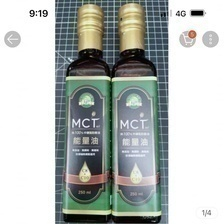

In [91]:
# 測試查詢
test_queries = [
    "我家狗晚上會繞圈圈，不知道是不是算失智症狀？我想提前準備好，有適合她活動的佈置嗎？"
    # "給我關於活動佈置可以參考的圖"
    # 'My dog ​​walks in circles at night. Is this a symptom of dementia? I want to prepare in advance. Is there a suitable layout for her event?'
    # "老狗失智症有什麼症狀？",
    # "晚上狗狗一直叫該怎麼辦？"
]

for query in test_queries:
    qa_system.display_response(query)
